In [1]:
# ---- importing functions ----
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# importing slow dynamics pipeline
pipeline_dir = 'C:/Users/ys2605/Desktop/stuff/slow_dynamics_analysis'    # edit this 
sys.path.append(pipeline_dir + '/functions')
from f_sd_utils import f_get_fnames_from_dir, f_load_caim_data, f_get_values, f_get_frames, f_get_stim_trig_resp, f_save_fig
from f_sd_decoder import f_run_binwise_dec, f_plot_binwise_dec, f_shuffle_trials

In [2]:
# ---- loading mismatch datasets ----
data_dir = 'F:/AC_data/caiman_data_missmatch/'   # edit this 
# search for files to load using tags in the filename
flist = f_get_fnames_from_dir(data_dir, ext_list = ['mat'], tags=['ammn', '_processed_data'])  # 'results_cnmf_sort'

# loading raw firing rates, trial types, and stimuli times
# here you can indicate to use oasis deconvolution or smoothdfdt
data_out = f_load_caim_data(data_dir, flist[:20], deconvolution='oasis', smooth_std_duration=0)

Text(0.5, 0, 'Frames')

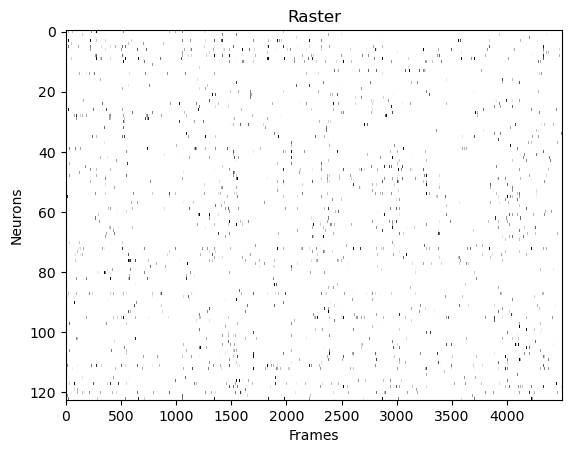

In [24]:
# ---- plot example raster ----
plt.figure()
plt.imshow(data_out[0]['firing_rates'][:,500:5000], aspect='auto', cmap='gist_yarg', vmin=0, vmax=.5, interpolation='none')
plt.title('Raster')
plt.ylabel('Neurons')
plt.xlabel('Frames')

In [3]:
# ---- extracting trials using stimulus times ----
# trial window to extract is indicated in seconds, also frame rate needs to be provided (assuming all datasets have similar frame rate)
trial_frames, plot_t = f_get_frames(trial_win = [-1, 3], frame_rate=1000/np.mean(f_get_values(data_out, 'volume_period')))

stim_trig_resp_all = []
for n_fl in range(len(data_out)):  
    # computing stimulus triggered average (neurons, frames, trials)
    stim_trig_resp = f_get_stim_trig_resp(data_out[n_fl]['firing_rates'], data_out[n_fl]['stim_times'], trial_frames=trial_frames)
    stim_trig_resp_all.append(stim_trig_resp)

In [4]:
# ---- training binwise decoder diagonally ----
train_test_method = 'diag'     # training options: full, diag, train_at_stim, test_at_stim

dec_data_all = []
for n_fl in range(len(data_out)):
    print('Training dataset %d/%d' % (n_fl+1, len(stim_trig_resp_all)))
    stim_trig_resp = stim_trig_resp_all[n_fl]
    trial_types = data_out[n_fl]['trial_types']
    trial_types_use = trial_types<=10
    
    X_all = [stim_trig_resp[:,:,trial_types_use], stim_trig_resp[:,:,trial_types_use]]
    # to creatae shuffled version we shuffle the trial types
    Y_all = [trial_types[trial_types_use], f_shuffle_trials(trial_types[trial_types_use])]
    
    dec_data = f_run_binwise_dec(X_all, Y_all, train_test_method=train_test_method, pca_var_frac = 1, num_cv=5, normalize = False, add_noise_sigma=1e-5, get_train_coeffs=True)
    dec_data_all.append(dec_data)

Training dataset 1/20
Training dataset 2/20
Training dataset 3/20
Training dataset 4/20
Training dataset 5/20
Training dataset 6/20
Training dataset 7/20
Training dataset 8/20
Training dataset 9/20
Training dataset 10/20
Training dataset 11/20
Training dataset 12/20
Training dataset 13/20
Training dataset 14/20
Training dataset 15/20
Training dataset 16/20
Training dataset 17/20
Training dataset 18/20
Training dataset 19/20
Training dataset 20/20


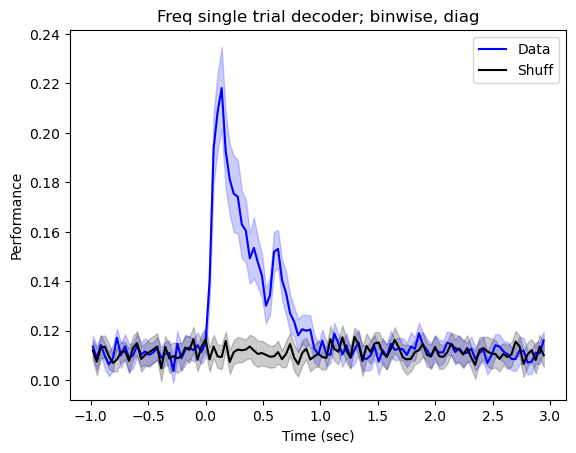

In [5]:
# ---- plotting diagonal decoder results ----
figs_diag = f_plot_binwise_dec(dec_data_all, plot_t=plot_t, plot_legend=('Data', 'Shuff'), plot_start=-1, plot_end=3, title_tag='Freq single trial decoder')

In [6]:
# ---- save figure ----
fig_dir = 'C:/Users/ys2605/Desktop/stuff/papers/AC_paper_protocol/figures/python'    # edit this
save_figs = False  # can turn on or off to save figure or not
if save_figs:    
    f_save_fig(figs_diag['diag_mean'], path=fig_dir, name_tag='')

dset 1 of 2; train bin 0/114
dset 1 of 2; train bin 1/114
dset 1 of 2; train bin 2/114
dset 1 of 2; train bin 3/114
dset 1 of 2; train bin 4/114
dset 1 of 2; train bin 5/114
dset 1 of 2; train bin 6/114
dset 1 of 2; train bin 7/114
dset 1 of 2; train bin 8/114
dset 1 of 2; train bin 9/114
dset 1 of 2; train bin 10/114
dset 1 of 2; train bin 11/114
dset 1 of 2; train bin 12/114
dset 1 of 2; train bin 13/114
dset 1 of 2; train bin 14/114
dset 1 of 2; train bin 15/114
dset 1 of 2; train bin 16/114
dset 1 of 2; train bin 17/114
dset 1 of 2; train bin 18/114
dset 1 of 2; train bin 19/114
dset 1 of 2; train bin 20/114
dset 1 of 2; train bin 21/114
dset 1 of 2; train bin 22/114
dset 1 of 2; train bin 23/114
dset 1 of 2; train bin 24/114
dset 1 of 2; train bin 25/114
dset 1 of 2; train bin 26/114
dset 1 of 2; train bin 27/114
dset 1 of 2; train bin 28/114
dset 1 of 2; train bin 29/114
dset 1 of 2; train bin 30/114
dset 1 of 2; train bin 31/114
dset 1 of 2; train bin 32/114
dset 1 of 2; train b

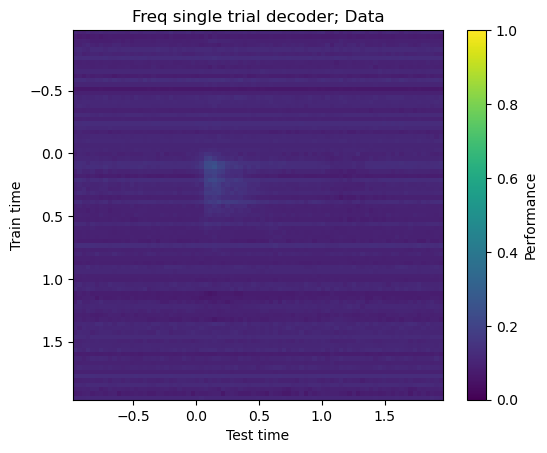

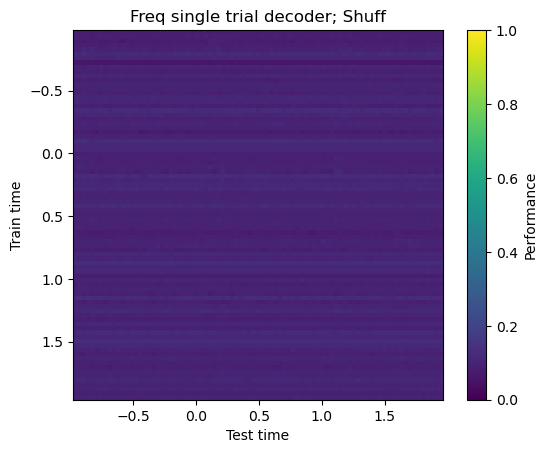

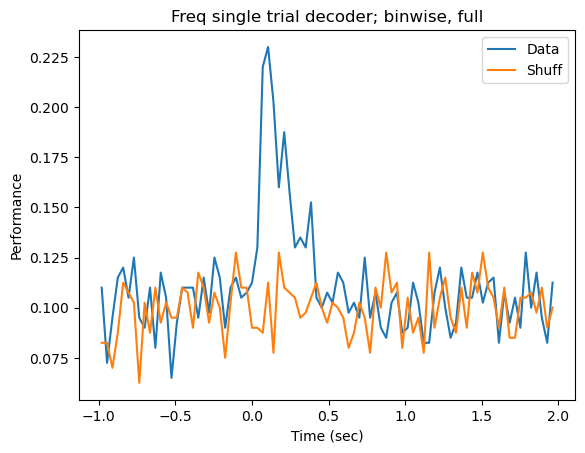

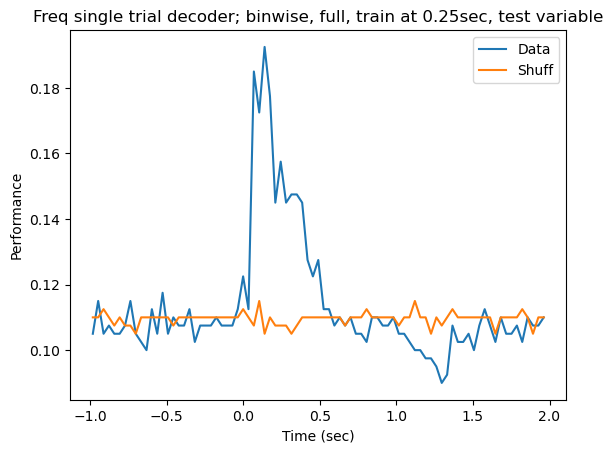

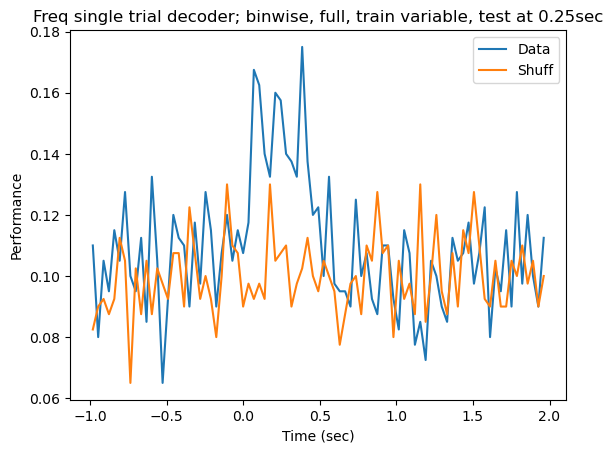

In [7]:
# ---- analyze the full decoding space ----
train_test_method = 'full'          # full, diag, train_at_stim, test_at_stim
n_fl = 0        # dataset to analyze

trial_types_use = data_out[n_fl]['trial_types']<=10

X_all = [stim_trig_resp_all[n_fl][:,:,trial_types_use], stim_trig_resp_all[n_fl][:,:,trial_types_use]]
Y_all = [data_out[n_fl]['trial_types'][trial_types_use], f_shuffle_trials(data_out[n_fl]['trial_types'][trial_types_use])]

dec_data_full = f_run_binwise_dec(X_all, Y_all, train_test_method=train_test_method, pca_var_frac = 1, num_cv=5, normalize = False, add_noise_sigma=1e-5, log=True)

figs_full = f_plot_binwise_dec(dec_data_full, plot_t=plot_t, plot_legend=('Data', 'Shuff'), plot_start=-1, plot_end=2, fixed_time=0.25, title_tag='Freq single trial decoder')

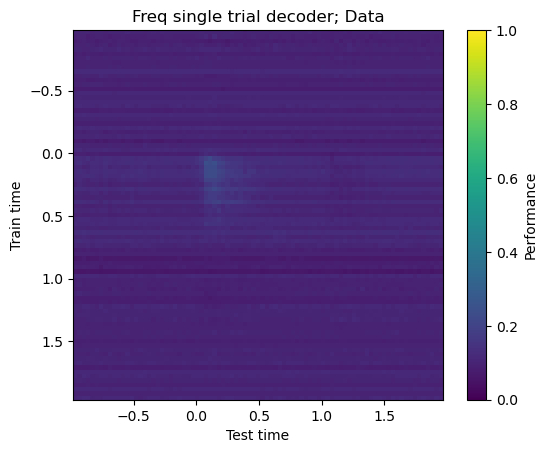

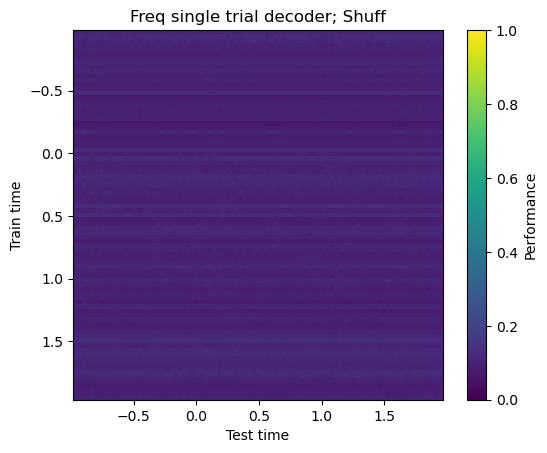

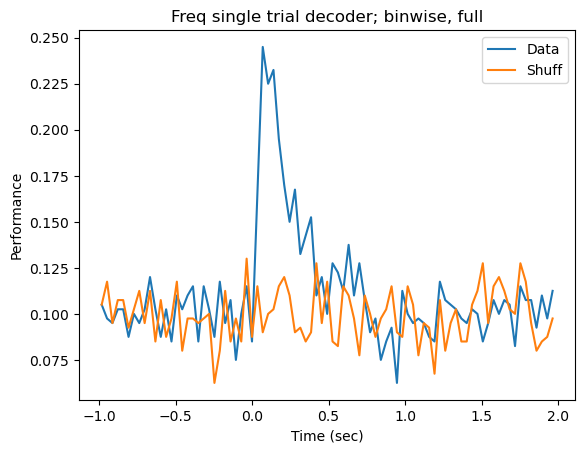

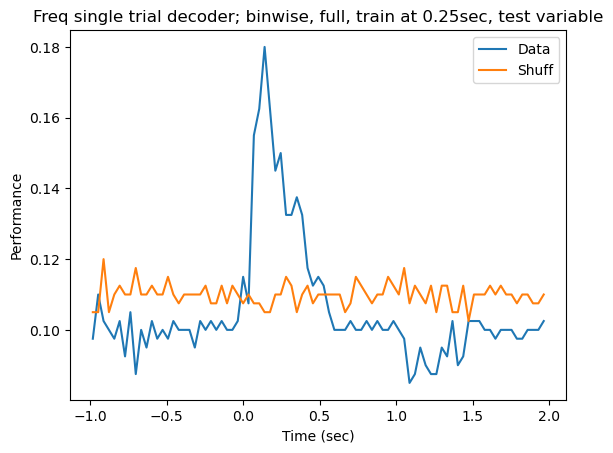

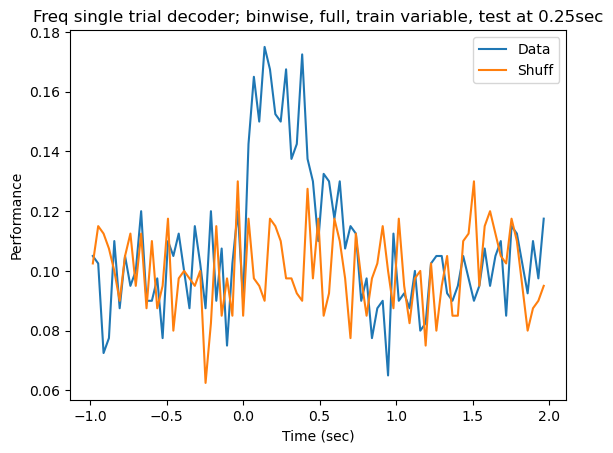

In [8]:
# ---- plotting full decoder results ----
figs_full = f_plot_binwise_dec(dec_data_full, plot_t=plot_t, plot_legend=('Data', 'Shuff'), plot_start=-1, plot_end=2, fixed_time=0.25, title_tag='Freq single trial decoder')
if save_figs:    
    f_save_fig(figs_full['full'][0], path=fig_dir, name_tag='data')
    f_save_fig(figs_full['full'][1], path=fig_dir, name_tag='shuff')